<h2> Convolutional Neural network using Pytorch </h2>
<h4> En este notebook, se utilizará Pytorch para entrenar una red neuronal convolucional que combina un autoencoder y un clasificador para predecir 10 clases de prendas del conocido conjunto de imágenes FashionMNIST </h4>
<h5>In this notebook, Pytorch will be used to train a convolutional neural network that combines an autoencoder and a classifier to predict 10 classes of clothes from the well-known image set FashionMNIST </h5>
Code developed by Pablo Merlo for the course "Redes Neuronales" of the Facultad de Matemática, Astronomía, Física y Computación, Universidad Nacional de Córdoba, 2023.

Load the librarys and packages needed:

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
#from torch.nn import functional as F
from torchviz import make_dot #to represent graphically my neural network
import matplotlib.pyplot as plt
import numpy as np
#from torchvision.io import read_image

In [120]:
torch.manual_seed(42) #reproductibility

In [121]:
# Step 2: Load and preprocess the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset_orig = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_orig = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
#train_size = 50000
batch_size = 100
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(train_dataset_orig, [train_size, val_size])

<h3> Training the AutoEncoder </h3>

In [122]:
#CREAMOS UNA SUBCLASE DE dATASET QUE SIRVA PARA MUESTREAR IMAGENES EN EL TRAINING DEL AUTOENCODER
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    #redefine the len method __len__()
    def __len__(self):
        return len(self.dataset)
    #Redefine metodoget item
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input= image
        output=image #RETORNA LA IMAGEN COMO SALIDA EN VEZ DEL FLATTEN QUE RETORNA EL DATASET
        return input,output

In [153]:
#train_set= CustomDataset(train_dataset)
train_set= CustomDataset(train_dataset_orig) #uso el train set completo, sin separar para validation
#valid_set= CustomDataset(val_dataset)
test_set= CustomDataset(test_dataset_orig)
#AHORA EN VEZ DE DEVOLVER EL LABEL DEVUELVE LA IMAGEN (return the image, not the label-->used for the autoencoder)

In [152]:
class Autoencoder_conv(nn.Module):
    def __init__(self, n=64, p=0.2):
        super().__init__()
        self.n = n
        self.p = p
        
        # Encoder
        self.encoder = nn.Sequential(
            # convolucion1
            nn.Conv2d(1,16,kernel_size=3), #(1,28,28) -> (16,26,26) PIERDO 2 de borde
            #nn.Conv2d: apply 2D convolution over an input signal composed of several input planes.
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2,2), #(16,26,26) -> (16,13,13)
            #MaxPooling is computing the max value for patches of a feature map & create a downsampled(pooled) feature map
            # convolucion2
            nn.Conv2d(16, 32, kernel_size=3),  # (16, 13, 13) -> (32, 11, 11)
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2, 2),  # (32, 11, 11) -> (32, 5, 5)
            #linear
            nn.Flatten(),  # (32, 5, 5) -> (32*5*5,)
            nn.Linear(32 * 5 * 5, self.n),  # (32*5*5,) -> (n,)
            nn.ReLU(),
            nn.Dropout(self.p)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            #linear_decoder
            nn.Linear(self.n, 32 * 5 * 5),  # (n,) -> (32*5*5,)
            nn.ReLU(),
            nn.Dropout(self.p),
            #nn.Linear(32 * 5 * 5, 32 * 5 * 5),  # Added a linear layer to match the size for reshaping
            #nn.ReLU(),
            nn.Unflatten(1, (32, 5, 5)),  # Reshape to (32, 5, 5)
            # conv_transpose1 es como hacer la inversa de la convolución, MaxPool está incluido en la transpuesta
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, output_padding=1),  # (32, 5, 5) -> (16, 13, 13)
            nn.ReLU(),
            nn.Dropout(self.p),
            # conv_transpose2
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1),  # (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid(), #nn.ReLU(),
            nn.Dropout(self.p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [154]:
#CREATE THE MODEL
n,p = 128,0.1 #64 es el n original y 0.2 el p
autoencoder_conv = Autoencoder_conv(n=n, p=p)
model = autoencoder_conv
model2= Autoencoder_conv(n=64, p=0.02)

In [126]:
autoencoder = Autoencoder_conv()  # Initialize the autoencoder
input_data = torch.randn(1, 1, 28, 28)  # Example input tensor (1 sample, 1 channel, 28x28)

output = autoencoder.forward(input_data)  # Pass the input through the autoencoder
print(output.size())  # Display the size of the output tensor

torch.Size([1, 1, 28, 28])


<h4> Visualizing ANN architechture </h4> 

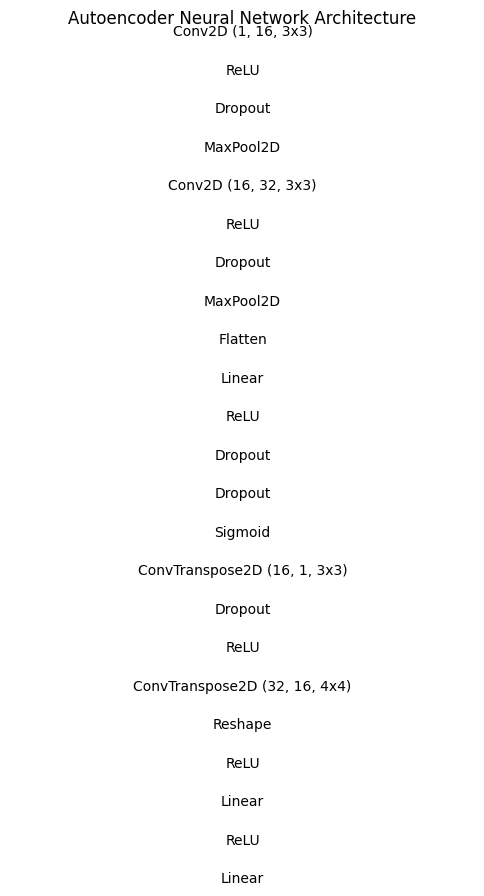

In [127]:
import matplotlib.image as mpimg

# Create a simple diagram to represent the architecture
def visualize_autoencoder():
    fig, ax = plt.subplots(figsize=(6, 5))

    # Encoder
    encoder_layers = [
        "Conv2D (1, 16, 3x3)", "ReLU", "Dropout",
        "MaxPool2D", "Conv2D (16, 32, 3x3)", "ReLU",
        "Dropout", "MaxPool2D", "Flatten", "Linear",
        "ReLU", "Dropout"
    ]

    # Decoder
    decoder_layers = [
        "Linear", "ReLU", "Linear", "ReLU", "Reshape",
        "ConvTranspose2D (32, 16, 4x4)", "ReLU", "Dropout",
        "ConvTranspose2D (16, 1, 3x3)", "Sigmoid", "Dropout"
    ]

    all_layers = encoder_layers + decoder_layers[::-1]

    for i, layer in enumerate(all_layers):
        ax.text(0.5, 1 - i * 0.1, layer, ha='center', va='center', fontsize=10, color='black')

    ax.set_axis_off()
    plt.title('Autoencoder Neural Network Architecture')
    plt.show()

visualize_autoencoder()

In [128]:
def batch(x):
    return x.unsqueeze(0)

def unbatch(x):
    return x.squeeze().detach().cpu().numpy()

In [129]:
# Example individual instance
single_instance = torch.tensor([1, 2, 3])

# Batch the instance
batched_instance = batch(single_instance)
print(batched_instance)

# Unbatch the instance
unbatched_instance = unbatch(batched_instance)
print(unbatched_instance)


tensor([[1, 2, 3]])
[1 2 3]


In [130]:
class_names = ["Remera","Pantalón","Pullover","Vestido", "Campera/Abrigo", "Sandalia", "Camisa", "Sneakers", "Bolso", "Botines"]

In [131]:
image,_ = train_dataset_orig[1]
pred = model(batch(image))
print(image.size())
#image.squeeze().detach().cpu().numpy().shape()
print(pred.size())
#print(unbatch(pred).size())

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


<h4> Model withouth training: </h4>

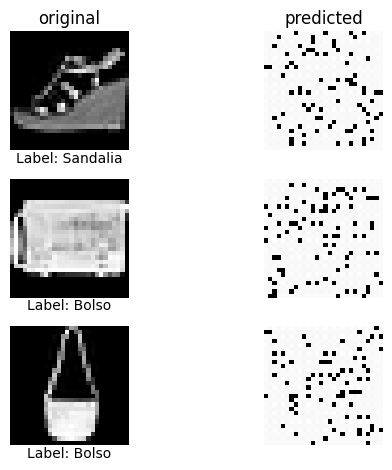

In [132]:
import torch
import matplotlib.pyplot as plt

figure = plt.figure()
rows, cols = 3, 2
i = 0  # subplot index

for row in range(1, rows + 1):
    j = torch.randint(len(train_dataset_orig), size=(1,)).item()  # nros random
    image, _ = train_dataset_orig[j]  # item random del train set

    # Plot the original image
    i += 1
    ax = figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title("original")
    plt.axis("off")
    plt.imshow(unbatch(image), cmap="Greys_r")
    
    # Get the class label
    class_label = class_names[train_dataset_orig[j][1]]

    # Add the class label below the image
    plt.text(0.5, -0.1, f"Label: {class_label}", transform=ax.transAxes, ha='center')

    # Plot the predicted image
    i += 1
    ax = figure.add_subplot(rows, cols, i)  # incomplete
    if row == 1:
        plt.title("predicted")
    plt.axis("off")
    
    # Assuming model and batch functions are defined
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred, cmap="Greys_r")

# Adjust layout for better visualization
plt.tight_layout()

# Save the figure
#plt.savefig('sinentrenar.tiff', dpi=300, bbox_inches='tight', facecolor='white')


In [133]:
class_names[train_dataset_orig[2][1]]

'Remera'

In [134]:
torch.cuda.is_available() #check gpu availability

False

In [135]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [136]:
#definimos funcion entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    #definimos algunas constantes
    size = len(dataloader.dataset)
    n_batches=len(dataloader)
    #seteamos error a cero al iniciar
    sum_loss= 0
    #model to gpu
    model= model.to(device)
    #start iterations:
    for batch, (X, y) in enumerate(dataloader):
        #movemos el lote a la gpu:
        X, y = X.to(device), y.to(device)
        
        ## Calculamos predicción y error en la misma
        pred = model(X)
        
        loss = loss_fn(pred, y)

        ## backpropagation
        optimizer.zero_grad() # Zero your gradients for every batch!
        loss.backward()
        optimizer.step() # Adjust learning weights
        
        #print progress:
        loss_batch = loss.item() 
        sum_loss += loss_batch
        if batch % 100 == 0:
            current= batch * len(X)
            print(f"@train_loop batch={batch:>4d} loss: {loss:>7f} muestras_procesadas: [{current:3d}/{size:3d}]")
    avg_loss= sum_loss/n_batches
    return avg_loss  

In [137]:
#definimos funcion testeo
def test_loop(dataloader, model, loss_fn):
    model.eval()
    #definimos algunas constantes
    size = len(dataloader.dataset)
    n_batches=len(dataloader)
    #seteamos error a cero al iniciar
    #sum_loss, sum_correct= 0,0
    sum_loss= 0.
    #model to gpu
    model= model.to(device)
    #start iterations:
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) 
            y_pred = model(X)
            loss_batch = loss_fn(y_pred,y).item() # en vez de y había x ( i.e: loss_fn(pred,x).item() ) antes
            sum_loss += loss_batch            
    avg_loss= sum_loss/n_batches  
    print(f"@train_loop Average_loss: {avg_loss:>5f}")
    return avg_loss

In [138]:
#create dataloaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size)
#valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)

In [139]:
#create an instance of the loss function 
loss_fn= nn.MSELoss() #Para autoencoder
#loss_fn= nn.CrossEntropyLoss() #classification

In [141]:
#create the optimizer: SGDescent or ADAM
learn_rate= 1e-3
#optimizer= torch.optim.SGD(model.parameters(), lr=learn_rate)
optimizer= torch.optim.Adam(model.parameters(), lr=learn_rate, eps=1e-8,weight_decay=0,amsgrad=False)
#optimizer= torch.optim.Adam(model2.parameters(), lr=learn_rate, eps=1e-8,weight_decay=0,amsgrad=False)

In [24]:
#AFTER SEVERAL TESTS, I'LL SHOW THE MODEL WITH LESS ERROR(LOSS)--> N=128; P=0.01
num_epochs = 20
list_avg_train_loss = []
#list_avg_valid_loss = [] 
list_avg_test_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} \n --------------------------")
    
    # Training
    avg_train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    list_avg_train_loss.append(avg_train_loss)

    # Testing
    avg_test_loss = test_loop(test_loader, model, loss_fn)
    list_avg_test_loss.append(avg_test_loss)

print("END")

Epoch 1 
 --------------------------
@train_loop batch=   0 loss: 0.229878 muestras_procesadas: [  0/60000]
@train_loop batch= 100 loss: 0.111291 muestras_procesadas: [10000/60000]
@train_loop batch= 200 loss: 0.088963 muestras_procesadas: [20000/60000]
@train_loop batch= 300 loss: 0.075453 muestras_procesadas: [30000/60000]
@train_loop batch= 400 loss: 0.070253 muestras_procesadas: [40000/60000]
@train_loop batch= 500 loss: 0.067654 muestras_procesadas: [50000/60000]
@train_loop Average_loss: 0.047143
Epoch 2 
 --------------------------
@train_loop batch=   0 loss: 0.065529 muestras_procesadas: [  0/60000]
@train_loop batch= 100 loss: 0.063636 muestras_procesadas: [10000/60000]
@train_loop batch= 200 loss: 0.062952 muestras_procesadas: [20000/60000]
@train_loop batch= 300 loss: 0.060391 muestras_procesadas: [30000/60000]
@train_loop batch= 400 loss: 0.060597 muestras_procesadas: [40000/60000]
@train_loop batch= 500 loss: 0.060293 muestras_procesadas: [50000/60000]
@train_loop Average

In [381]:
np.mean(list_avg_test_loss)

0.048981587139165235

In [142]:
#To show how the models with the hiperparameters described above is superior, 
#i'll train another model with different hiperparameters--> N=64; P=0.02
#train model2
num_epochs = 16
list_avg_train_loss_n64 = []
#list_avg_valid_loss = [] 
list_avg_test_loss_n64 = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} \n --------------------------")
    
    # Training
    avg_train_loss = train_loop(train_loader, model2, loss_fn, optimizer)
    list_avg_train_loss_n64.append(avg_train_loss)

    # Testing
    avg_test_loss = test_loop(test_loader, model2, loss_fn)
    list_avg_test_loss_n64.append(avg_test_loss)

print("END")

Epoch 1 
 --------------------------
@train_loop batch=   0 loss: 0.184551 muestras_procesadas: [  0/60000]
@train_loop batch= 100 loss: 0.086470 muestras_procesadas: [10000/60000]
@train_loop batch= 200 loss: 0.065043 muestras_procesadas: [20000/60000]
@train_loop batch= 300 loss: 0.053154 muestras_procesadas: [30000/60000]
@train_loop batch= 400 loss: 0.049887 muestras_procesadas: [40000/60000]
@train_loop batch= 500 loss: 0.046438 muestras_procesadas: [50000/60000]
@train_loop Average_loss: 0.039730
Epoch 2 
 --------------------------
@train_loop batch=   0 loss: 0.043868 muestras_procesadas: [  0/60000]
@train_loop batch= 100 loss: 0.043563 muestras_procesadas: [10000/60000]
@train_loop batch= 200 loss: 0.042997 muestras_procesadas: [20000/60000]
@train_loop batch= 300 loss: 0.040032 muestras_procesadas: [30000/60000]
@train_loop batch= 400 loss: 0.039914 muestras_procesadas: [40000/60000]
@train_loop batch= 500 loss: 0.039654 muestras_procesadas: [50000/60000]
@train_loop Average

In [146]:
import json

In [41]:
#I save the error loss for the best model to comparison with other test in the search of the optimum hyperparameter
with open("train.json", 'w') as f:
    json.dump(list_avg_train_loss, f)
    
with open("test.json", 'w') as t:
    json.dump(list_avg_test_loss, t)

In [147]:
with open("train.json", 'r') as f:
    train_loss = json.load(f)

In [148]:
with open("test.json", 'r') as f:
    test_loss = json.load(f)

np.mean(test_loss)

0.0328201499148272

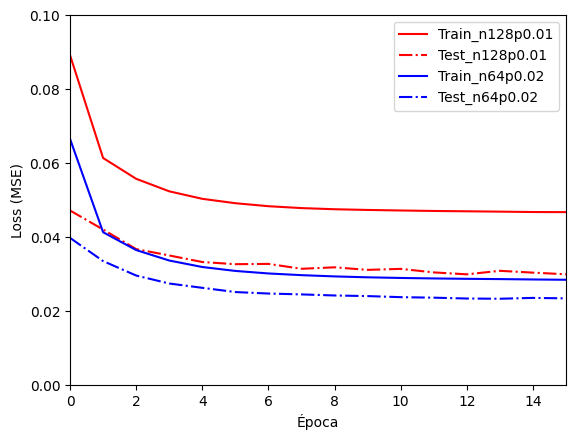

In [151]:
#comparison between Autoencoder with n=128neurons and p=0.01(model1) and n=64, p=0.02 (models2)
 
from matplotlib.ticker import MaxNLocator

plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.ylim(0,0.10)
plt.xlim(0,15)
plt.plot(train_loss, label="Train_n128p0.01", linestyle='-', c='red')
plt.plot(test_loss, label="Test_n128p0.01", linestyle='-.',c='red')
plt.plot(list_avg_train_loss_n64, label="Train_n64p0.02", linestyle='-', c='blue')
plt.plot(list_avg_test_loss_n64, label="Test_n64p0.02", linestyle='-.',c='blue')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

#plt.savefig('loss_p0_1.tiff', dpi=300, bbox_inches='tight', facecolor='white')

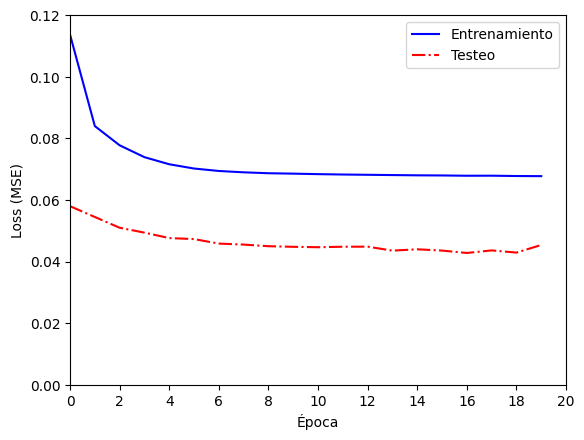

In [74]:
#another test--> n=256 
from matplotlib.ticker import MaxNLocator

plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.ylim(0,0.12)
plt.xlim(0,20)
plt.plot(list_avg_train_loss, label="Entrenamiento", linestyle='-', c='blue')
plt.plot(list_avg_test_loss, label="Testeo", linestyle='-.',c='red')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

#plt.savefig('loss_n256.tiff', dpi=300, bbox_inches='tight', facecolor='white')

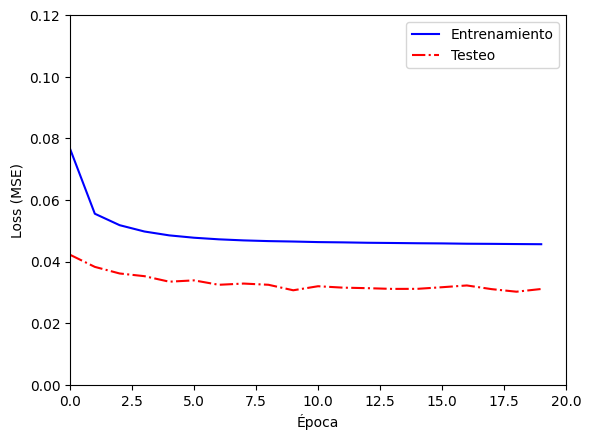

In [217]:
#FINAL MODEL LOSS PLOTTED ALONE:
plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.ylim(0,0.12)
plt.xlim(0,20)
plt.plot(list_avg_train_loss, label="Entrenamiento", linestyle='-', c='blue')
plt.plot(list_avg_test_loss, label="Testeo", linestyle='-.',c='red')
plt.legend()

#plt.savefig('loss_n128p01.tiff', dpi=300, bbox_inches='tight', facecolor='white')

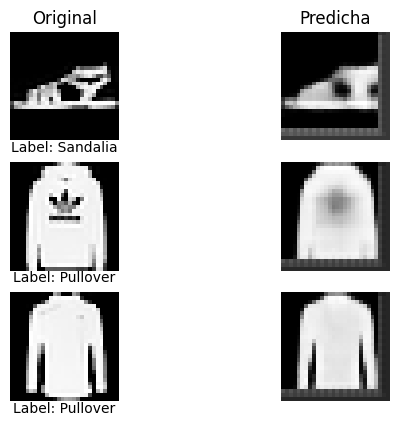

In [220]:
#PLOT ORIGINAL IMAGES VS IMAGES PREDICTED ('predicha') BY THE AUTOENCODER 
figure= plt.figure()
rows,cols= 3,2
i=0 #subplot index
model.eval()
for row in range(1,rows+1):
    j=torch.randint(len(test_loader),size=(1,)).item()
    #plot original image:
    i +=1
    image, flatten_image = test_dataset_orig[j]
    figure.add_subplot(rows,cols,i)
    if row== 1:
        plt.title("Original")
    plt.axis("off")
    plt.imshow(unbatch(image),cmap="Greys_r")
    
    # Get the class label
    class_label = class_names[test_dataset_orig[j][1]]

    # Add the class label below the image
    plt.text(0.5, -0.1, f"Label: {class_label}", transform=plt.gca().transAxes, ha='center')
    
    #plot predicted image:
    i +=1
    figure.add_subplot(rows,cols,i)
    if row== 1:
        plt.title("Predicha")
    plt.axis("off")
    pred=unbatch(model(batch(image)))
    plt.imshow(pred,cmap="Greys_r")

#plt.savefig('entrenado.tiff', dpi=300, bbox_inches='tight', facecolor='white')

<h3> I Then going to use the pretrained ENCODER as part of my classifier </h3>

In [97]:
import copy
trained_encoder = copy.deepcopy(model.encoder) 
#trained_encoder = model.encoder #soft copy, both instances of the same object

In [98]:
#check encoder output size:
def get_encoder_output_size(encoder):
        # Helper function to get the output size of the encoder
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)  # Replace input_size with the actual input size
            encoder_output = trained_encoder(dummy_input)
        return encoder_output.view(1, -1).size(1)

In [99]:
get_encoder_output_size(trained_encoder) #is the number of neurons

128

In [100]:
#FIRST, i test a classifier (Clasificador) with 1 hidden layer, that maps from 128 neurons to 10 output neurons
class Clasificador_Conv(nn.Module):
    def __init__(self, trained_encoder, n=128, p=0.2): #n=n of neurons of encoder
        super().__init__()
        #self.n = n
        self.p = p
        #Encoder: usas el que ya teneés entrenado
        self.encoder= trained_encoder
        #Clasificador
        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Softmax(dim=1) ## Add softmax activation for multi-class classification
        )
    def forward(self,x):
        x= self.encoder(x)
        x= self.classifier(x)
        return x

In [101]:
#THEN, i test a classifier with 2 hidden layer:
##-hidden1 maps from 128 to 64 neurons; -hidden2 maps from 64 to 10 output neurons:
class Clasificador_Conv(nn.Module):
    def __init__(self, trained_encoder, n=64, p=0.2): #n=n of neurons of encoder
        super().__init__()
        #self.n = n
        self.p = p
        #Encoder: usas el que ya teneés entrenado
        self.encoder= trained_encoder
        #Clasificador
        self.classifier = nn.Sequential(
            #nn.Flatten(),  # Flatten the encoder's output
            nn.Linear(128, 64),  # Adjust input size based on encoder output
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 10),   # Output layer with 10 classes
            #nn.Sigmoid()
            nn.Softmax(dim=1)
        )
    def forward(self,x):
        x= self.encoder(x)
        x= self.classifier(x)
        return x

In [ ]:
#After several tests, the classifier with 2 hidden layers was evidenced as a better architecture (better performance without too high computing cost)
clasificador_conv= Clasificador_Conv(trained_encoder)
model_f= clasificador_conv
model_f

In [104]:
an_image,label= train_dataset_orig[2]
an_image.shape
#batch(an_image) 

torch.Size([1, 28, 28])

In [105]:
pred=model_f(batch(image))

class_names[pred.argmax(1)]

'Remera'

In [106]:
class_names[train_dataset_orig[2][1]]

'Remera'

In [107]:
#definimos funcion entrenamiento
def train_loop2(dataloader, model_f, loss_fn, optimizer):
    model_f.train()
    #definimos algunas constantes
    size = len(dataloader.dataset)
    n_batches=len(dataloader)
    #seteamos error a cero al iniciar
    sum_loss= 0
    sum_predichos_correctos= 0
    
    #model to gpu
    model_f= model_f.to(device)
    #start iterations:
    for batch, (X, y) in enumerate(dataloader):
        #movemos el lote a la gpu:
        X, y = X.to(device), y.to(device)
        ## Calculamos predicción y error en la misma
        pred = model_f(X)
        loss = loss_fn(pred, y)

        ## backpropagation
        optimizer.zero_grad() # Zero your gradients for every batch!
        loss.backward()
        optimizer.step() # Adjust learning weights
        
        #print progress:
        loss_value = loss.item() 
        sum_loss += loss_value
        sum_predichos_correctos += torch.sum(pred.argmax(1) == y).item()
        if batch % 100 == 0:
            current= batch * len(X)
            print(f"@train_loop batch={batch:>5d} loss: {loss:>3f} muestras_procesadas: [{current:5d}/{size:5d}]")
    avg_loss= sum_loss/n_batches
    fraccion_correct = sum_predichos_correctos/n_batches
    return avg_loss, fraccion_correct 

In [108]:
#definimos funcion testeo
def test_loop2(dataloader, model_f, loss_fn):
    model_f.eval()
    #definimos algunas constantes
    size = len(dataloader.dataset)
    n_batches=len(dataloader)
    #seteamos error a cero al iniciar
    sum_loss, sum_predichos_correctos= 0,0
    #sum_loss= 0.
    #model to gpu
    model_f= model_f.to(device)
    #start iterations:
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) 
            y_pred = model_f(X)
            sum_loss += loss_fn(y_pred,y).item()
            sum_predichos_correctos += torch.sum(y_pred.argmax(1) == y).item()
    avg_loss= sum_loss/n_batches  
    fraccion_correct = sum_predichos_correctos/n_batches
    print(f"@test_loop Average_loss: {avg_loss:>3f}")
    return avg_loss,fraccion_correct

In [109]:
len(test_loader_f)

100

In [110]:
batch_size= 100
train_loader_f = DataLoader(train_dataset_orig, batch_size= batch_size, shuffle=True)
test_loader_f = DataLoader(test_dataset_orig, batch_size= batch_size, shuffle=True)

In [111]:
len(train_loader_f)

600

In [112]:
loss_fn= nn.CrossEntropyLoss()

In [113]:
l_rate=1e-3
#optimizer= torch.optim.Adam(model_f.classifier.parameters(), lr=l_rate, eps=1e-8,weight_decay=0,amsgrad=False)
optimizer = torch.optim.Adam(model_f.parameters(), lr=l_rate, amsgrad=False)

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model_f=model_f.to(device)

In [115]:
num_epochs=25
list_avg_train_loss = []
list_avg_test_loss = []
list_precision_train = []
list_precision_test = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} \n --------------------------")
    
    # Training
    avg_train_loss,train_precision = train_loop2(train_loader_f, model_f, loss_fn, optimizer)
    list_avg_train_loss.append(avg_train_loss)
    list_precision_train.append(train_precision)

    # Testing
    avg_test_loss, test_precision = test_loop2(test_loader_f, model_f, loss_fn)
    list_avg_test_loss.append(avg_test_loss)
    list_precision_test.append(test_precision)

print("END, very well!")

Epoch 1 
 --------------------------
@train_loop batch=    0 loss: 2.305965 muestras_procesadas: [    0/60000]
@train_loop batch=  100 loss: 1.686083 muestras_procesadas: [10000/60000]
@train_loop batch=  200 loss: 1.716593 muestras_procesadas: [20000/60000]
@train_loop batch=  300 loss: 1.703958 muestras_procesadas: [30000/60000]
@train_loop batch=  400 loss: 1.641976 muestras_procesadas: [40000/60000]
@train_loop batch=  500 loss: 1.700614 muestras_procesadas: [50000/60000]
@test_loop Average_loss: 1.653475
Epoch 2 
 --------------------------
@train_loop batch=    0 loss: 1.597509 muestras_procesadas: [    0/60000]
@train_loop batch=  100 loss: 1.680097 muestras_procesadas: [10000/60000]
@train_loop batch=  200 loss: 1.699360 muestras_procesadas: [20000/60000]
@train_loop batch=  300 loss: 1.640621 muestras_procesadas: [30000/60000]
@train_loop batch=  400 loss: 1.660460 muestras_procesadas: [40000/60000]
@train_loop batch=  500 loss: 1.636107 muestras_procesadas: [50000/60000]
@tes

In [116]:
def format_func(value, tick_number):
    return f"{int(value)}"

In [118]:
np.mean(list_precision_test)

87.32400000000001

In [119]:
list_precision_test

[81.2,
 83.73,
 84.95,
 85.59,
 86.35,
 86.78,
 85.67,
 87.36,
 87.51,
 87.02,
 87.65,
 88.43,
 88.12,
 87.73,
 88.33,
 88.44,
 88.49,
 88.35,
 88.76,
 88.97,
 88.77,
 88.88,
 88.98,
 88.14,
 88.9]

In [ ]:
from matplotlib.ticker import FuncFormatter
plt.xlabel("Época")
plt.ylabel("Loss")
plt.ylim(1.5,2)
plt.xlim(0,20)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.plot(list_avg_train_loss, label="Loss: Entrenamiento",linestyle='-',c='blue')
plt.plot(list_avg_test_loss, label=":Loss: Testeo",linestyle='-',c='red')
#plt.plot(list_precision_train, label="Precision: Entrenamiento",linestyle='-.',c='blue')
#plt.plot(list_precision_test, label=":Precision: Testeo",linestyle='-.',c='red')
plt.legend()
#plt.savefig('loss_precision_dropout0.2_n128_simple.tiff', dpi=300, bbox_inches='tight', facecolor='white')

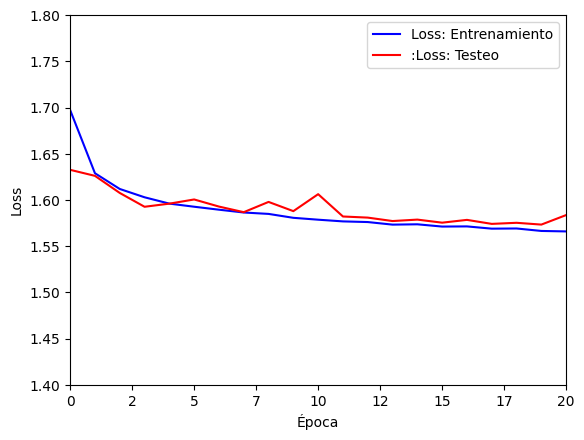

In [459]:
#Plot error of train and test of the best models
from matplotlib.ticker import FuncFormatter
plt.xlabel("Época")
plt.ylabel("Loss")
plt.ylim(1.4,1.8)
plt.xlim(0,20)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.plot(list_avg_train_loss, label="Loss: Entrenamiento",linestyle='-',c='blue')
plt.plot(list_avg_test_loss, label=":Loss: Testeo",linestyle='-',c='red')
#plt.plot(list_precision_train, label="Precision: Entrenamiento",linestyle='-.',c='blue')
#plt.plot(list_precision_test, label=":Precision: Testeo",linestyle='-.',c='red')
plt.legend()
#plt.savefig('loss_precision_dropout0.2_n128_.tiff', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
np.mean(list_avg_test_loss)

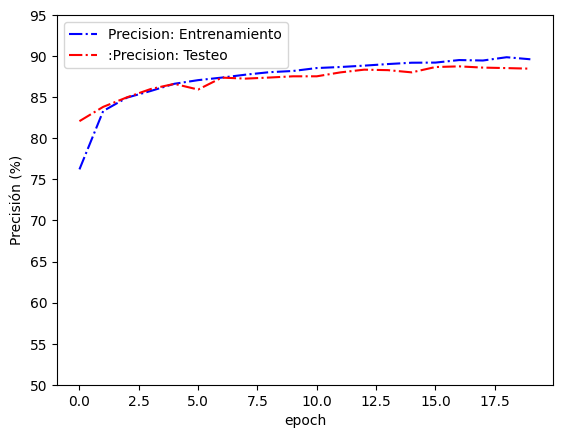

In [425]:
#Plot Predicition precision (in percentage) on train and test sets for the best model!
plt.xlabel("epoch")
plt.ylabel("Precisión (%)")
plt.ylim(50,95)
#plt.plot(list_avg_train_loss, label="Loss: Entrenamiento",linestyle='-',c='blue')
#plt.plot(list_avg_test_loss, label=":Loss: Testeo",linestyle='-',c='red')
plt.plot(list_precision_train, label="Precision: Entrenamiento",linestyle='-.',c='blue')
plt.plot(list_precision_test, label=":Precision: Testeo",linestyle='-.',c='red')
plt.legend()
#plt.savefig('precision_dropout0.1n128.tiff', dpi=300, bbox_inches='tight', facecolor='white')

In [485]:
np.mean(list_precision_test)

87.56640000000002

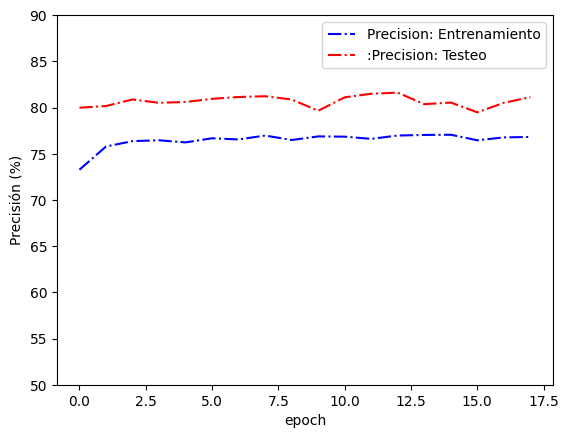

In [334]:
#TEST WITH P=0.5 (several tests changing values of p,n and other hyperparameters were performed to determine the optimum values)
plt.xlabel("epoch")
plt.ylabel("Precisión (%)")
plt.ylim(50,90)
#plt.plot(list_avg_train_loss, label="Loss: Entrenamiento",linestyle='-',c='blue')
#plt.plot(list_avg_test_loss, label=":Loss: Testeo",linestyle='-',c='red')
plt.plot(list_precision_train, label="Precision: Entrenamiento",linestyle='-.',c='blue')
plt.plot(list_precision_test, label=":Precision: Testeo",linestyle='-.',c='red')
plt.legend()
plt.savefig('precision_dropout0.5.tiff', dpi=300, bbox_inches='tight', facecolor='white')

In [120]:
y_pred=[]
y_true=[]

size= len(test_loader_f.dataset)
for batch, (inputs,labels) in enumerate(test_loader_f):
    outputs=model_f(inputs)
    outputs_f= (torch.max(torch.exp(outputs),1)[1]).data.cpu().numpy()
    y_pred.extend(outputs_f)
    
    labels= labels.data.cpu().numpy()
    y_true.extend(labels)

In [121]:
len(class_names)

10

In [122]:
#PREDICTED INSTANCES FOR EACH CLASS
from collections import Counter

# Count occurrences using Counter
class_counts = Counter(y_pred)

# Print the result
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} occurrences")

Class 0: 1078 occurrences
Class 5: 969 occurrences
Class 9: 1022 occurrences
Class 7: 1007 occurrences
Class 1: 965 occurrences
Class 6: 1075 occurrences
Class 4: 892 occurrences
Class 3: 1011 occurrences
Class 2: 985 occurrences
Class 8: 996 occurrences


In [123]:
#TRUE NUMBER OF INSTANCES FOR EACH CLASS
class_counts_true = Counter(y_true)

# Print the result
for class_label, count in class_counts_true.items():
    print(f"Class {class_label}: {count} occurrences")

Class 0: 1000 occurrences
Class 5: 1000 occurrences
Class 9: 1000 occurrences
Class 7: 1000 occurrences
Class 1: 1000 occurrences
Class 6: 1000 occurrences
Class 2: 1000 occurrences
Class 4: 1000 occurrences
Class 8: 1000 occurrences
Class 3: 1000 occurrences


In [125]:
# Map numeric labels to class names in the new list
y_true_labels = [class_names[label] for label in y_true]
y_pred_labels = [class_names[label] for label in y_pred]

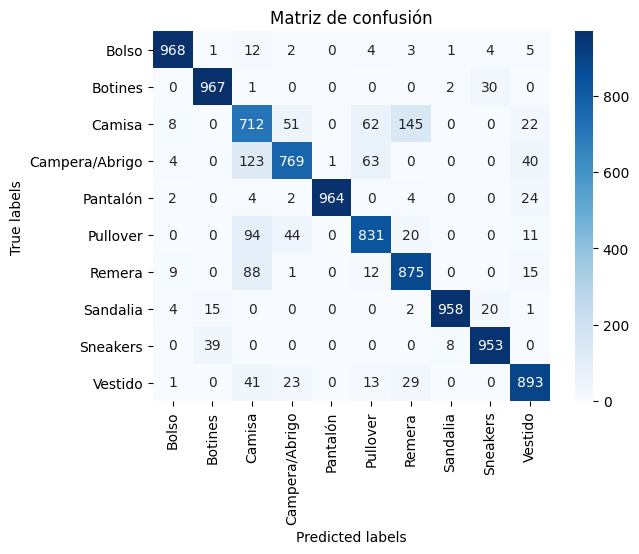

In [126]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cm = confusion_matrix(y_true_labels , y_pred_labels )

# Visualize confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_true_labels ), yticklabels=np.unique(y_true_labels ))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de confusión')

plt.savefig('cm_dropout0.2n128_bothoptimization.tiff', dpi=300, bbox_inches='tight', facecolor='white') 
#LABELS IN SPANISH